In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from statsmodels.stats.proportion import proportion_confint
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import os
import sklearn.metrics as metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# 1. Loading data and preprocessing

In [3]:
initial_df = pd.read_csv("C:\\Users\\Lukasz\\Downloads\\final_airplanes.csv")
initial_df.head(5)

,satisfaction,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay Winsorized,Arrival Delay Winsorized
0,dissatisfied,Loyal Customer,48,Personal Travel,Eco,4001,1,1,1,1,...,1,1,4,1,1,4,2,1,16,0.0
1,dissatisfied,Loyal Customer,48,Personal Travel,Eco,3980,1,1,1,1,...,4,4,2,3,2,3,2,4,0,0.0
2,dissatisfied,Loyal Customer,40,Personal Travel,Eco,2251,1,1,1,1,...,1,1,3,3,2,1,1,1,0,8.0
3,dissatisfied,Loyal Customer,46,Personal Travel,Eco,2453,1,1,1,1,...,5,3,1,4,1,2,2,3,3,15.0
4,dissatisfied,Loyal Customer,63,Personal Travel,Eco,2011,1,1,1,1,...,5,5,1,5,2,1,2,5,25,25.0


In [4]:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119255 entries, 0 to 119254
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       119255 non-null  object 
 1   Customer Type                      119255 non-null  object 
 2   Age                                119255 non-null  int64  
 3   Type of Travel                     119255 non-null  object 
 4   Class                              119255 non-null  object 
 5   Flight Distance                    119255 non-null  int64  
 6   Seat comfort                       119255 non-null  int64  
 7   Departure/Arrival time convenient  119255 non-null  int64  
 8   Food and drink                     119255 non-null  int64  
 9   Gate location                      119255 non-null  int64  
 10  Inflight wifi service              119255 non-null  int64  
 11  Inflight entertainment             1192

# 2. Modelling

In [6]:
# Separate features and target
X = initial_df.drop("satisfaction", axis = 1)
y = initial_df["satisfaction"]

# Split the data (%80 train and %20 test)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train_raw.shape[0]} samples")
print(f"Testing set size: {X_test_raw.shape[0]} samples")
print(f"\nTarget distribution in training set:")
print(y_train.value_counts(normalize=True))
print(f"\nTarget distribution in testing set:")
print(y_test.value_counts(normalize=True))

Training set size: 95404 samples
Testing set size: 23851 samples

Target distribution in training set:
satisfaction
satisfied       0.541434
dissatisfied    0.458566
Name: proportion, dtype: float64

Target distribution in testing set:
satisfaction
satisfied       0.541445
dissatisfied    0.458555
Name: proportion, dtype: float64


In [7]:
def preprocess_for_decision_tree_ohe(X_train, X_test, drop_first=False):
    """
    Preprocess data for Decision Tree using:
    - One-Hot Encoding for categorical variables
    - NO scaling for numerical variables (not needed for tree models)
    - Leakage-safe: fit ONLY on training data
    """

    # Identify columns
    categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
    numerical_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

    # Numerical pipeline: passthrough (no scaling)
    numeric_transformer = "passthrough"

    # Categorical pipeline: One-Hot Encoding
    categorical_transformer = Pipeline(steps=[
        ("onehot", OneHotEncoder(
            drop="first" if drop_first else None,
            handle_unknown="ignore",
            sparse_output=False
        ))
    ])

    # Combine transformations
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_cols),
            ("cat", categorical_transformer, categorical_cols)
        ],
        remainder="drop"
    )

    # Fit ONLY on training, transform both
    X_train_arr = preprocessor.fit_transform(X_train)
    X_test_arr = preprocessor.transform(X_test)

    # Feature names
    cat_feature_names = []
    if len(categorical_cols) > 0:
        cat_feature_names = list(
            preprocessor.named_transformers_["cat"]
            .named_steps["onehot"]
            .get_feature_names_out(categorical_cols)
        )
    feature_names = numerical_cols + cat_feature_names

    # Convert to DataFrame
    X_train_final = pd.DataFrame(X_train_arr, columns=feature_names, index=X_train.index)
    X_test_final = pd.DataFrame(X_test_arr, columns=feature_names, index=X_test.index)

    return X_train_final, X_test_final, preprocessor


# create an UNFITTED preprocessor for CV/Pipeline to avoid optimistic CV scores
def make_dt_preprocessor(X, drop_first=False):
    categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
    numerical_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

    numeric_transformer = "passthrough"
    categorical_transformer = Pipeline(steps=[
        ("onehot", OneHotEncoder(
            drop="first" if drop_first else None,
            handle_unknown="ignore",
            sparse_output=False
        ))
    ])

    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numerical_cols),
            ("cat", categorical_transformer, categorical_cols)
        ],
        remainder="drop"
    )


# APPLY PREPROCESSING 
X_train_dt, X_test_dt, dt_preprocessor = preprocess_for_decision_tree_ohe(
    X_train_raw, X_test_raw, drop_first=False
)

dt_preprocessor_cv = make_dt_preprocessor(X_train_raw, drop_first=False)


# TARGET ENCODING
le_target = LabelEncoder()
y_train_encoded = le_target.fit_transform(y_train)
y_test_encoded = le_target.transform(y_test)

print("X_train_dt shape:", X_train_dt.shape)
print("X_test_dt shape:", X_test_dt.shape)
print("Classes:", le_target.classes_.tolist())

X_train_dt shape: (95404, 25)
X_test_dt shape: (23851, 25)
Classes: ['dissatisfied', 'satisfied']


- Categorical and numerical columns are automatically identified based on data types.
- Numerical features are passed through without scaling, since Decision Trees do not require feature scaling.
- Categorical features are transformed using one-Hot Encoding:
  - `drop_first=False` keeps all dummy variables (acceptable for tree-based models).
  - `handle_unknown="ignore"` prevents errors if unseen categories appear in the test set.
  - `sparse_output=False` produces dense output for easier conversion to DataFrames.
- Numerical and categorical transformations are combined using a ColumnTransformer.
- Preprocessing is leakage-safe:
  - The transformer is fitted only on the training data.
  - The test data is only transformed using the fitted transformer.
- Feature names created after One-Hot Encoding are extracted and preserved.
- The transformed train and test matrices are converted into pandas DataFrames, keeping original indices.
- A separate unfitted preprocessor is created for cross-validation to avoid optimistic CV scores.
- The target variable is encoded using LabelEncoder:
  - The encoder is fitted only on `y_train`.
  - `y_test` is transformed using the fitted encoder.
- The processed train/test shapes and class labels are printed for verification.

## 2.1 Initial model

In [10]:
#Running the decision tree classifier with the Gini criterion
initial_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
initial_tree = initial_tree.fit(X_train_dt,y_train_encoded)

Below a decision tree with depth 3 is displayed in order to acheive a clear and easy to read output

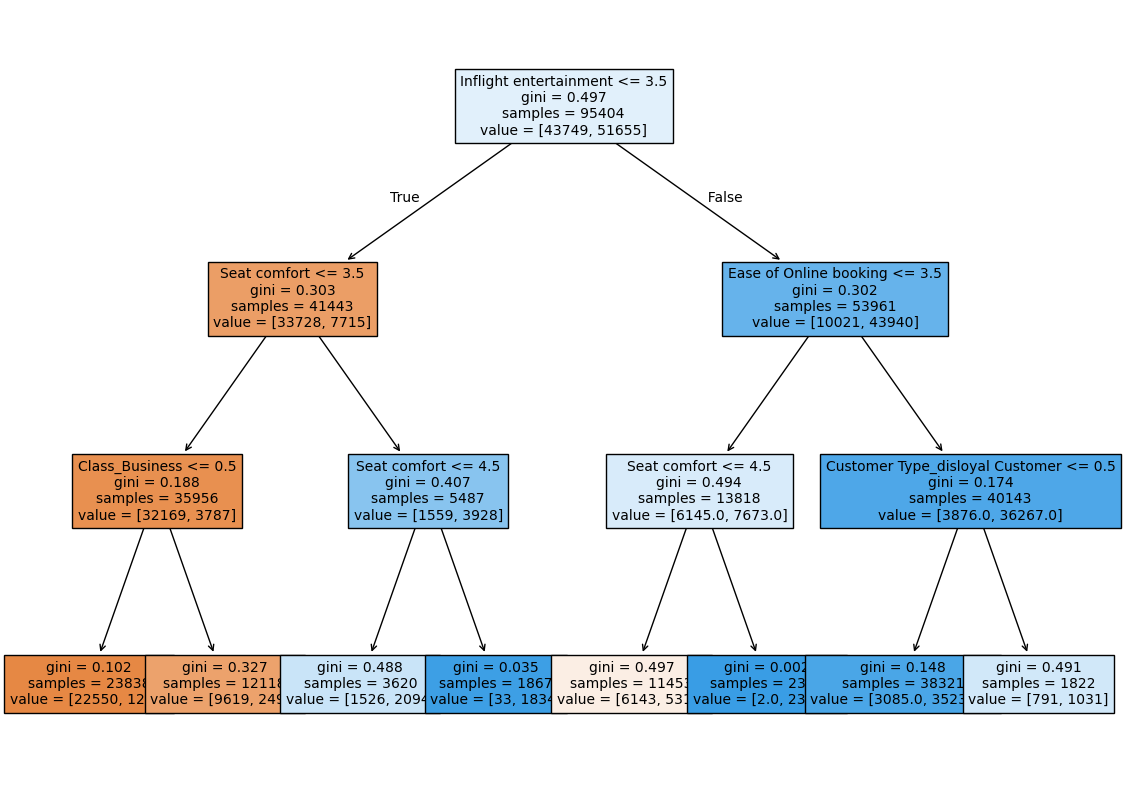

In [12]:
feature_names = X_train_dt.columns.tolist()

plt.figure(figsize=(14,10))
plot_tree(initial_tree, feature_names=feature_names, filled=True, fontsize=10)
plt.show()

- `Inflight entertainment` is the most important feature and a root node, as it provides the largest reduction in impurity with gini = 0.497. This suggest that high rating of `Inflight entertainment` pushes customers into being satisfied with the overall experience
-  `seat comfort`  and `ease of online booking` are the next most influential factors in determining passenger satisfaction
- moreover, `Class_Business` and `Customer Type_disloyal Customer` also seem to be playing a significant role in the base decision tree model. People in business class seem to be satisfied more often, while disloyal customers end up being dissatisfied more often

In [14]:
y_pred = initial_tree.predict(X_test_dt)

In [15]:
#Test data accuracy of the model with depth 3
accuracy = metrics.accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8489371514821181


In [16]:
#Other metrics
precision = precision_score(y_test_encoded, y_pred, pos_label=1)
recall = recall_score(y_test_encoded, y_pred, pos_label=1)
f1 = f1_score(y_test_encoded, y_pred, pos_label=1)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.886573113011708
Recall: 0.8267771410871922
F1-score: 0.8556316865007814


<Axes: >

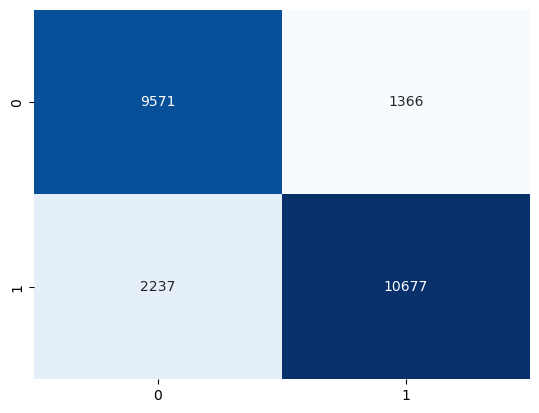

In [17]:
#Visualisation of the confusion matrix
cf_matrix = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

The number of false negatives (1366) is lower than false positives (2237), meaning the model is slightly better at identifying satisfied customers than unsatisfied ones. Earlier in the project we specified that there are slightly more satisfied customers (54%) than dissatisfied (46%). This could have an influence on the value of false positives being higher than false negatives in the base decision tree model.

In [19]:
param_grid = {
    'max_depth': list(range(1, 30))
}

#Base model
tree_model = DecisionTreeClassifier(random_state=42)

#Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=tree_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train_dt, y_train_encoded)
best_tree = grid_search.best_estimator_

#Best parameters and score
print("Best max_depth:", grid_search.best_params_['max_depth'])
print("Best CV Accuracy:", grid_search.best_score_)

#Extract CV results
cv_results = grid_search.cv_results_
cv_scores_mean = cv_results['mean_test_score']
cv_scores_std = cv_results['std_test_score']
tree_depths = param_grid['max_depth']

Best max_depth: 16
Best CV Accuracy: 0.9395412962525314


Cross validation was used in order to define the best depth of the tree, to detect possible overfitting and stabilize the results by acheiving less variance

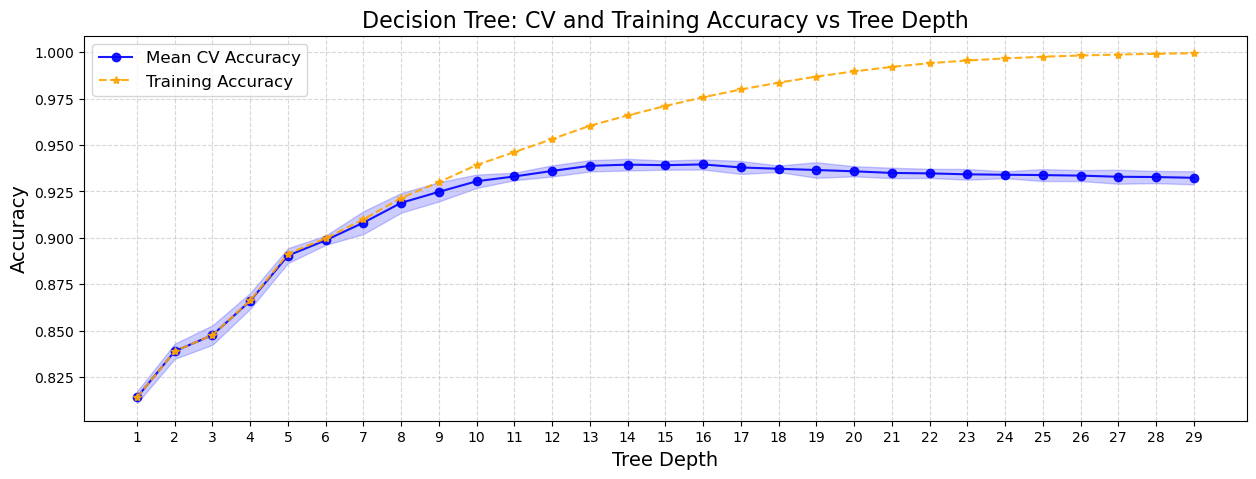

In [42]:
# Training accuracy from GridSearchCV
train_scores_mean = grid_search.cv_results_['mean_train_score']

fig, ax = plt.subplots(figsize=(15,5))

# Mean cross-validation accuracy
ax.plot(tree_depths, cv_scores_mean, marker='o', linestyle='-', color='blue', 
        label='Mean CV Accuracy', alpha=0.9)

# ±2 std deviation
ax.fill_between(tree_depths, 
                cv_scores_mean - 2*cv_scores_std, 
                cv_scores_mean + 2*cv_scores_std, 
                color='blue', alpha=0.2)

# Training accuracy
ax.plot(tree_depths, train_scores_mean, marker='*', linestyle='--', color='orange', 
        label='Training Accuracy', alpha=0.9)

# Labels and title
ax.set_title("Decision Tree: CV and Training Accuracy vs Tree Depth", fontsize=16)
ax.set_xlabel("Tree Depth", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)

# X-axis ticks
ax.set_xticks(tree_depths)

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=12)

plt.show()

Decision Tree cross-validation results and the analysis of max depth

The figure above shows the relationship between tree depth and model accuracy for a Decision Tree classifier. Two metrics are displayed:

- Mean cross-validation accuracy (blue line): average accuracy across cross-validation folds
- Training accuracy (orange line): accuracy measured on the training dataset

At small depths, both training and cross-validation accuracy are relatively low. This indicates underfitting, as the tree is not complex enough to capture the underlying patterns in the data. Increasing depth improves performance initially as the tree depth increases, both training and cross-validation accuracy improve significantly. This shows that the model is learning more meaningful structure from the data.
Cross-validation accuracy reaches its maximum around depth 13–16. This range represents the best trade-off between bias and variance, where the model generalizes well to unseen data. As we look at ecen higher depths we can see that training accuracy continues to increase and approaches 100%, while cross-validation accuracy plateaus or begins to slightly decline. This indicates overfitting. The model is not improving its performance on unseen data. While the figure above allows us to see the trends of model behaviour at different depths, to obtain the optimal depth we need to look at the output below.

In [44]:
idx_max = cv_scores_mean.argmax()
sm_best_tree_depth = tree_depths[idx_max]
sm_best_tree_cv_score = cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = cv_scores_std[idx_max]
print("Accuracy at each tree depth:")
for depth, mean_score, std_score in zip(tree_depths, cv_scores_mean, cv_scores_std):
    print("Depth {}: {:.5f} +/- {:.5f}".format(depth, mean_score, std_score))

Accuracy at each tree depth:
Depth 1: 0.81410 +/- 0.00158
Depth 2: 0.83893 +/- 0.00204
Depth 3: 0.84766 +/- 0.00262
Depth 4: 0.86603 +/- 0.00213
Depth 5: 0.89043 +/- 0.00201
Depth 6: 0.89873 +/- 0.00126
Depth 7: 0.90818 +/- 0.00308
Depth 8: 0.91886 +/- 0.00265
Depth 9: 0.92478 +/- 0.00259
Depth 10: 0.93049 +/- 0.00180
Depth 11: 0.93307 +/- 0.00101
Depth 12: 0.93604 +/- 0.00151
Depth 13: 0.93880 +/- 0.00152
Depth 14: 0.93943 +/- 0.00158
Depth 15: 0.93915 +/- 0.00123
Depth 16: 0.93954 +/- 0.00138
Depth 17: 0.93791 +/- 0.00173
Depth 18: 0.93721 +/- 0.00088
Depth 19: 0.93654 +/- 0.00209
Depth 20: 0.93584 +/- 0.00136
Depth 21: 0.93496 +/- 0.00141
Depth 22: 0.93472 +/- 0.00122
Depth 23: 0.93422 +/- 0.00144
Depth 24: 0.93399 +/- 0.00092
Depth 25: 0.93381 +/- 0.00162
Depth 26: 0.93352 +/- 0.00148
Depth 27: 0.93291 +/- 0.00188
Depth 28: 0.93275 +/- 0.00165
Depth 29: 0.93234 +/- 0.00176


After obtaining the depth for the best mean cross-validation accuracy we can run the final base Decision Tree model with depth 16

In [46]:
#Running the decision tree classifier with the Gini criterion
optimal_tree = tree.DecisionTreeClassifier(criterion='gini', max_depth=16, random_state=42)
optimal_tree = optimal_tree.fit(X_train_dt,y_train_encoded)

In [48]:
y_train_pred = optimal_tree.predict(X_train_dt)
y_test_pred = optimal_tree.predict(X_test_dt)

# Probabilities for ROC-AUC
y_train_prob = optimal_tree.predict_proba(X_train_dt)[:, 1]
y_test_prob = optimal_tree.predict_proba(X_test_dt)[:, 1]

# Accuracy
train_acc = accuracy_score(y_train_encoded, y_train_pred)
test_acc = accuracy_score(y_test_encoded, y_test_pred)

# Precision
train_prec = precision_score(y_train_encoded, y_train_pred)
test_prec = precision_score(y_test_encoded, y_test_pred)

# Recall
train_rec = recall_score(y_train_encoded, y_train_pred)
test_rec = recall_score(y_test_encoded, y_test_pred)

# F1-score
train_f1 = f1_score(y_train_encoded, y_train_pred)
test_f1 = f1_score(y_test_encoded, y_test_pred)

# ROC-AUC
train_auc = roc_auc_score(y_train_encoded, y_train_prob)
test_auc = roc_auc_score(y_test_encoded, y_test_prob)

# Differences
diff_acc = train_acc - test_acc
diff_prec = train_prec - test_prec
diff_rec = train_rec - test_rec
diff_f1 = train_f1 - test_f1
diff_auc = train_auc - test_auc

# Display results
print(f"Training Accuracy:  {train_acc:.4f}")
print(f"Testing Accuracy:   {test_acc:.4f}")
print(f"Difference:         {diff_acc:.4f}")
print("-" * 35)

print(f"Training Precision: {train_prec:.4f}")
print(f"Testing Precision:  {test_prec:.4f}")
print(f"Difference:         {diff_prec:.4f}")
print("-" * 35)

print(f"Training Recall:    {train_rec:.4f}")
print(f"Testing Recall:     {test_rec:.4f}")
print(f"Difference:         {diff_rec:.4f}")
print("-" * 35)

print(f"Training F1-score:  {train_f1:.4f}")
print(f"Testing F1-score:   {test_f1:.4f}")
print(f"Difference:         {diff_f1:.4f}")
print("-" * 35)

print(f"Training ROC-AUC:   {train_auc:.4f}")
print(f"Testing ROC-AUC:    {test_auc:.4f}")
print(f"Difference:         {diff_auc:.4f}")

Training Accuracy:  0.9749
Testing Accuracy:   0.9398
Difference:         0.0351
-----------------------------------
Training Precision: 0.9839
Testing Precision:  0.9501
Difference:         0.0339
-----------------------------------
Training Recall:    0.9695
Testing Recall:     0.9382
Difference:         0.0313
-----------------------------------
Training F1-score:  0.9767
Testing F1-score:   0.9441
Difference:         0.0326
-----------------------------------
Training ROC-AUC:   0.9976
Testing ROC-AUC:    0.9593
Difference:         0.0383


- The model achieves very high accuracy on the training data, indicating it fits the training set well. The drop in accuracy on the test set is relatively small (≈3.5%), suggestingoverall good generalization to unseen data.
- The AUC values are extremely high for both training and testing sets. An AUC close to 1 indicates very good class separability. The test AUC of 0.9593 confirms that the model remains highly effective at distinguishing between classes on unseen data.

<Axes: >

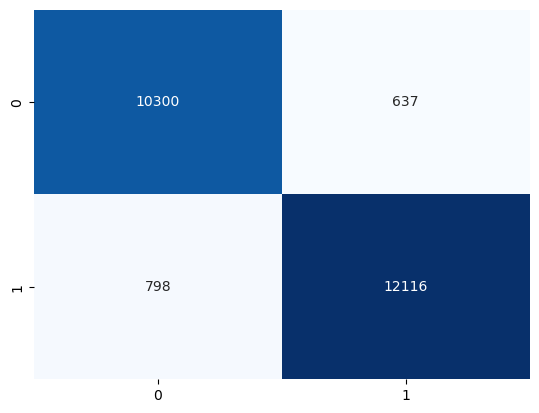

In [50]:
cf_matrix = confusion_matrix(y_test_encoded, y_test_pred)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

By looking at the confusion matrix we can also conclude that the final decision tree model at depth 16 performs much better with less false positives and false negatives. It is also worth mentioning that the disparity between false positives and false negatives is much smaller than in the case of the model of depth 3.

## 2.2 Bagging Classifier

In the next step of our project we applied the bagging clasifier (bootstrap aggregation). This ensembling method was used to try and handle the problem of slight overfitting in the initial decision tree model. Thanks to the fact that this method takes many different subsets of the training data and combines their predictions it can help to reduce variance and overfitting.

In [52]:
base_tree = DecisionTreeClassifier(random_state=42)

# Bagging model
bagging_model = BaggingClassifier(
    estimator=base_tree,
    n_estimators=30,
    random_state=42,
    n_jobs=-1
)

# Parameter grid (tuning tree depth)
param_grid = {
    'estimator__max_depth': list(range(1, 30))
}

# GridSearchCV setup
grid_search_bagging = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)

# Fit grid search
grid_search_bagging.fit(X_train_dt, y_train_encoded)

# Best model and parameters
best_bagging_model = grid_search_bagging.best_estimator_
best_depth = grid_search_bagging.best_params_['estimator__max_depth']
best_score = grid_search_bagging.best_score_

print(f"Best tree depth: {best_depth}")
print(f"Best CV accuracy: {best_score:.5f}")

# Extract CV results
cv_results = grid_search_bagging.cv_results_
tree_depths = param_grid['estimator__max_depth']
cv_scores_mean = cv_results['mean_test_score']
cv_scores_std = cv_results['std_test_score']

Best tree depth: 28
Best CV accuracy: 0.95184


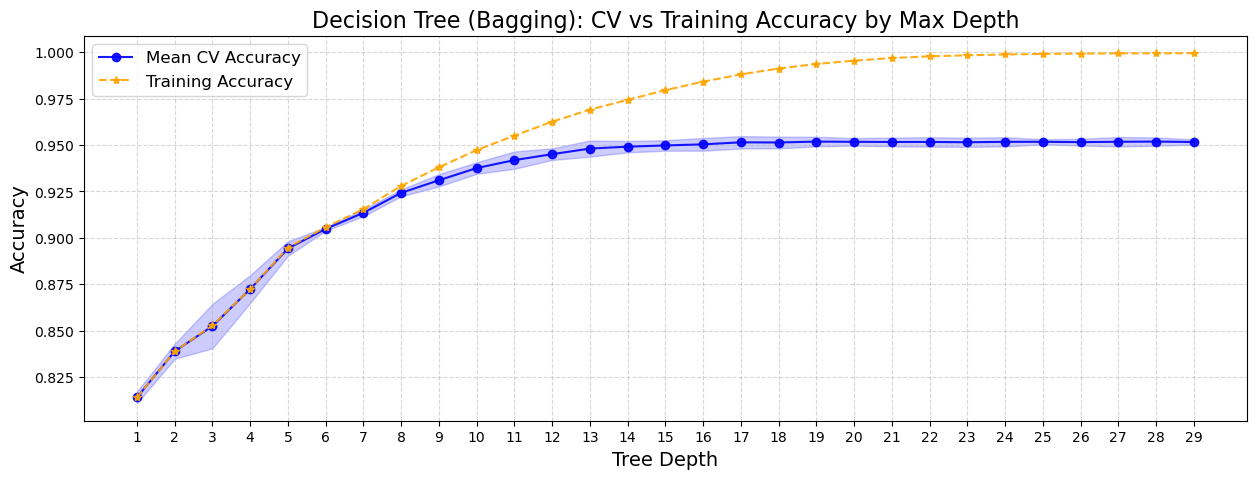

In [58]:
# Extract training scores from GridSearchCV
train_scores_mean = grid_search_bagging.cv_results_['mean_train_score']

# CV scores from GridSearchCV
cv_scores_mean_bag = grid_search_bagging.cv_results_['mean_test_score']
cv_scores_std_bag = grid_search_bagging.cv_results_['std_test_score']

# Tree depths
tree_depths = param_grid['estimator__max_depth']

fig, ax = plt.subplots(figsize=(15,5))

# Plot mean cross-validation accuracy
ax.plot(tree_depths, cv_scores_mean_bag, marker='o', linestyle='-', color='blue', 
        label='Mean CV Accuracy', alpha=0.9)

# Fill ±2 std deviation
ax.fill_between(tree_depths, 
                cv_scores_mean_bag - 2*cv_scores_std_bag, 
                cv_scores_mean_bag + 2*cv_scores_std_bag, 
                color='blue', alpha=0.2)

# Plot training accuracy
ax.plot(tree_depths, train_scores_mean, marker='*', linestyle='--', color='orange', 
        label='Training Accuracy', alpha=0.9)

# Labels and title
ax.set_title("Decision Tree (Bagging): CV vs Training Accuracy by Max Depth", fontsize=16)
ax.set_xlabel("Tree Depth", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)

# X-axis ticks
ax.set_xticks(tree_depths)

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=12)

plt.show()

In [60]:
idx_max = cv_scores_mean.argmax()
sm_best_tree_depth = tree_depths[idx_max]
sm_best_tree_cv_score = cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = cv_scores_std[idx_max]
print("Accuracy at each tree depth:")
for depth, mean_score, std_score in zip(tree_depths, cv_scores_mean, cv_scores_std):
    print("Depth {}: {:.5f} +/- {:.5f}".format(depth, mean_score, std_score))

Accuracy at each tree depth:
Depth 1: 0.81410 +/- 0.00158
Depth 2: 0.83893 +/- 0.00204
Depth 3: 0.85249 +/- 0.00599
Depth 4: 0.87242 +/- 0.00375
Depth 5: 0.89427 +/- 0.00196
Depth 6: 0.90482 +/- 0.00051
Depth 7: 0.91348 +/- 0.00090
Depth 8: 0.92422 +/- 0.00092
Depth 9: 0.93101 +/- 0.00166
Depth 10: 0.93757 +/- 0.00155
Depth 11: 0.94185 +/- 0.00234
Depth 12: 0.94504 +/- 0.00156
Depth 13: 0.94806 +/- 0.00217
Depth 14: 0.94909 +/- 0.00154
Depth 15: 0.94975 +/- 0.00142
Depth 16: 0.95034 +/- 0.00171
Depth 17: 0.95144 +/- 0.00167
Depth 18: 0.95133 +/- 0.00159
Depth 19: 0.95182 +/- 0.00131
Depth 20: 0.95171 +/- 0.00101
Depth 21: 0.95161 +/- 0.00118
Depth 22: 0.95164 +/- 0.00127
Depth 23: 0.95146 +/- 0.00124
Depth 24: 0.95169 +/- 0.00124
Depth 25: 0.95170 +/- 0.00071
Depth 26: 0.95153 +/- 0.00090
Depth 27: 0.95172 +/- 0.00129
Depth 28: 0.95184 +/- 0.00112
Depth 29: 0.95160 +/- 0.00069


Based on the cross-validation results, the decision tree achieves increasing accuracy as depth increases, reaching a peak mean accuracy of 95.184% at depth 28. However, the improvement in accuracy beyond depth 19 is minimal (less than 0.03%) while the complexity of the tree continues to increase. Considering both predictive performance and model simplicity, a tree depth of 19 was selected. This depth provides nearly the maximum achievable accuracy, maintains low variance, and avoids unnecessary complexity, ensuring better generalization to unseen data.

In [62]:
# Base decision tree
base_tree = DecisionTreeClassifier(max_depth=19, random_state=42)

# Bagging model
bagging_model = BaggingClassifier(
    estimator=base_tree,
    n_estimators=30,
    random_state=42,
    n_jobs=-1
)

# Fit the model
bagging_model.fit(X_train_dt, y_train_encoded)

# Predictions
y_train_pred = bagging_model.predict(X_train_dt)
y_test_pred = bagging_model.predict(X_test_dt)

# Probabilities for ROC-AUC
y_train_prob = bagging_model.predict_proba(X_train_dt)[:, 1]
y_test_prob = bagging_model.predict_proba(X_test_dt)[:, 1]

# Accuracy
train_acc = accuracy_score(y_train_encoded, y_train_pred)
test_acc = accuracy_score(y_test_encoded, y_test_pred)

# Precision
train_prec = precision_score(y_train_encoded, y_train_pred)
test_prec = precision_score(y_test_encoded, y_test_pred)

# Recall
train_rec = recall_score(y_train_encoded, y_train_pred)
test_rec = recall_score(y_test_encoded, y_test_pred)

# F1-score
train_f1 = f1_score(y_train_encoded, y_train_pred)
test_f1 = f1_score(y_test_encoded, y_test_pred)

# ROC-AUC
train_auc = roc_auc_score(y_train_encoded, y_train_prob)
test_auc = roc_auc_score(y_test_encoded, y_test_prob)

# Differences
diff_acc = train_acc - test_acc
diff_prec = train_prec - test_prec
diff_rec = train_rec - test_rec
diff_f1 = train_f1 - test_f1
diff_auc = train_auc - test_auc

# Display results
print(f"Training Accuracy:  {train_acc:.4f}")
print(f"Testing Accuracy:   {test_acc:.4f}")
print(f"Difference:         {diff_acc:.4f}")
print("-" * 35)

print(f"Training Precision: {train_prec:.4f}")
print(f"Testing Precision:  {test_prec:.4f}")
print(f"Difference:         {diff_prec:.4f}")
print("-" * 35)

print(f"Training Recall:    {train_rec:.4f}")
print(f"Testing Recall:     {test_rec:.4f}")
print(f"Difference:         {diff_rec:.4f}")
print("-" * 35)

print(f"Training F1-score:  {train_f1:.4f}")
print(f"Testing F1-score:   {test_f1:.4f}")
print(f"Difference:         {diff_f1:.4f}")
print("-" * 35)

print(f"Training ROC-AUC:   {train_auc:.4f}")
print(f"Testing ROC-AUC:    {test_auc:.4f}")
print(f"Difference:         {diff_auc:.4f}")

Training Accuracy:  0.9924
Testing Accuracy:   0.9517
Difference:         0.0407
-----------------------------------
Training Precision: 0.9966
Testing Precision:  0.9639
Difference:         0.0327
-----------------------------------
Training Recall:    0.9892
Testing Recall:     0.9461
Difference:         0.0431
-----------------------------------
Training F1-score:  0.9929
Testing F1-score:   0.9549
Difference:         0.0380
-----------------------------------
Training ROC-AUC:   0.9996
Testing ROC-AUC:    0.9914
Difference:         0.0082


- The bagging model provides slightly better performance than the base decision tree model with the test accuracy being higher by around 1 percentage point.
- It returns a near perfect AUC on the dest data which schowcases that the model can seperate classes extremely reliably

<Axes: >

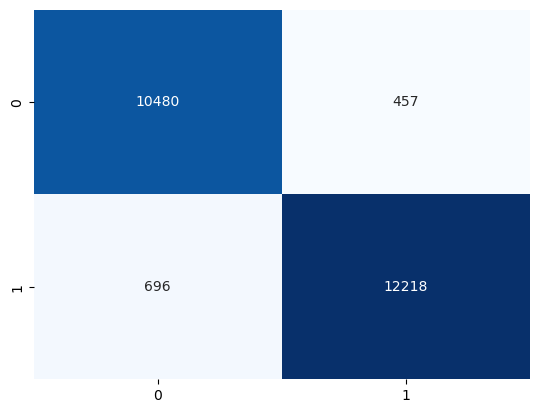

In [64]:
cf_matrix = confusion_matrix(y_test_encoded, y_test_pred)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

## 2.3 AdaBoost

In [66]:
base_tree = DecisionTreeClassifier(random_state=42)

# AdaBoost model
adaboost_model = AdaBoostClassifier(
    estimator=base_tree,
    n_estimators=30,
    random_state=42
)

# Parameter grid (tuning tree depth)
param_grid = {
    'estimator__max_depth': list(range(1, 15))
}

# GridSearchCV setup
grid_search_adaboost = GridSearchCV(
    estimator=adaboost_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True
)

# Fit grid search
grid_search_adaboost.fit(X_train_dt, y_train_encoded)

# Best model and parameters
best_adaboost_model = grid_search_adaboost.best_estimator_
best_depth = grid_search_adaboost.best_params_['estimator__max_depth']
best_score = grid_search_adaboost.best_score_

print(f"Best tree depth: {best_depth}")
print(f"Best CV accuracy: {best_score:.5f}")

# Extract CV results
cv_results = grid_search_adaboost.cv_results_
tree_depths = param_grid['estimator__max_depth']
cv_scores_mean_ab = cv_results['mean_test_score']
cv_scores_std_ab = cv_results['std_test_score']

C:\Users\Lukasz\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best tree depth: 5
Best CV accuracy: 0.94569


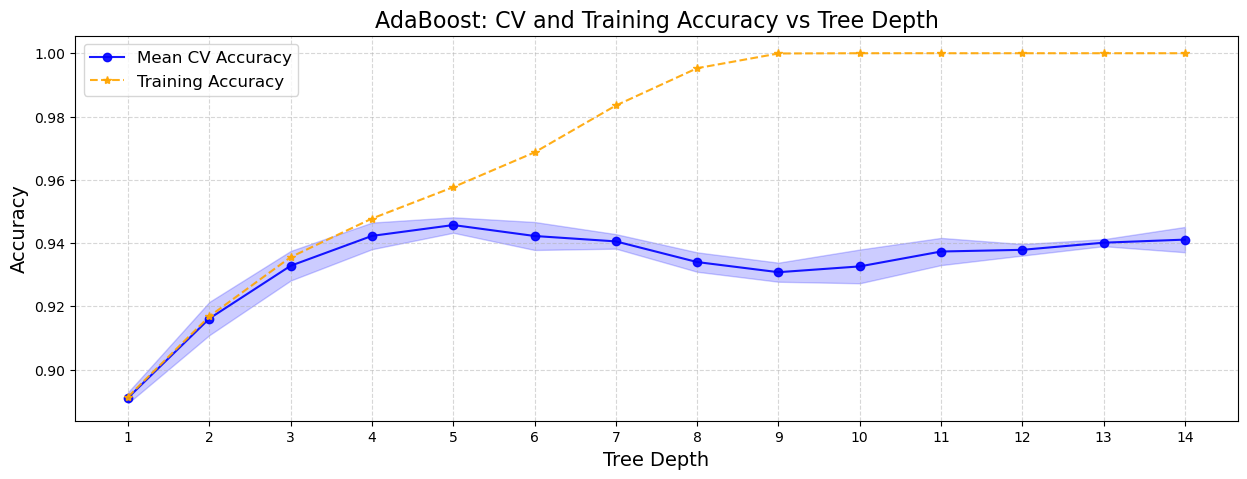

In [73]:
#Obtaining the depth with the best mean cross-validation accuracy for the bagging model
train_scores_mean = grid_search_adaboost.cv_results_['mean_train_score']


fig, ax = plt.subplots(figsize=(15,5))

# Plot mean cross-validation accuracy
ax.plot(tree_depths, cv_scores_mean_ab, marker='o', linestyle='-', color='blue', 
        label='Mean CV Accuracy', alpha=0.9)

# Fill ±2 std deviation
ax.fill_between(tree_depths, 
                cv_scores_mean_ab - 2*cv_scores_std_ab, 
                cv_scores_mean_ab + 2*cv_scores_std_ab, 
                color='blue', alpha=0.2)

# Plot training accuracy
ax.plot(tree_depths, train_scores_mean, marker='*', linestyle='--', color='orange', 
        label='Training Accuracy', alpha=0.9)

# Labels and title
ax.set_title("AdaBoost: CV and Training Accuracy vs Tree Depth", fontsize=16)
ax.set_xlabel("Tree Depth", fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)

# X-axis ticks
ax.set_xticks(tree_depths)

# Grid and legend
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(fontsize=12)

plt.show()

In [75]:
idx_max = cv_scores_mean_ab.argmax()
sm_best_tree_depth = tree_depths[idx_max]
sm_best_tree_cv_score = cv_scores_mean_ab[idx_max]
sm_best_tree_cv_score_std = cv_scores_std_ab[idx_max]
print("Accuracy at each tree depth:")
for depth, mean_score, std_score in zip(tree_depths, cv_scores_mean_ab, cv_scores_std_ab):
    print("Depth {}: {:.5f} +/- {:.5f}".format(depth, mean_score, std_score))

Accuracy at each tree depth:
Depth 1: 0.89113 +/- 0.00087
Depth 2: 0.91616 +/- 0.00263
Depth 3: 0.93283 +/- 0.00234
Depth 4: 0.94227 +/- 0.00210
Depth 5: 0.94569 +/- 0.00122
Depth 6: 0.94224 +/- 0.00221
Depth 7: 0.94053 +/- 0.00115
Depth 8: 0.93400 +/- 0.00153
Depth 9: 0.93079 +/- 0.00151
Depth 10: 0.93262 +/- 0.00267
Depth 11: 0.93733 +/- 0.00215
Depth 12: 0.93786 +/- 0.00091
Depth 13: 0.94012 +/- 0.00055
Depth 14: 0.94109 +/- 0.00200


For the AdaBoost model, the cross-validation results show that the mean accuracy increases steadily with tree depth up to depth 5, reaching a peak of approximately 94.57% with a very low standard deviation of 0.12%, indicating stable performance. Beyond depth 5, the mean accuracy begins to decrease slightly, therefore suggesting that deeper trees will start to overfit. Ultimately, a tree depth of 5 was selected for AdaBoost, as it provides the best balance between predictive performance and model stability, maximizing accuracy while avoiding overfitting.

In [77]:
best_adaboost_model.fit(X_train_dt, y_train_encoded)

# Predictions
y_train_pred = best_adaboost_model.predict(X_train_dt)
y_test_pred = best_adaboost_model.predict(X_test_dt)

# Probabilities for ROC-AUC
y_train_prob = best_adaboost_model.predict_proba(X_train_dt)[:, 1]
y_test_prob = best_adaboost_model.predict_proba(X_test_dt)[:, 1]

# Accuracy
train_acc = accuracy_score(y_train_encoded, y_train_pred)
test_acc = accuracy_score(y_test_encoded, y_test_pred)

# Precision
train_prec = precision_score(y_train_encoded, y_train_pred)
test_prec = precision_score(y_test_encoded, y_test_pred)

# Recall
train_rec = recall_score(y_train_encoded, y_train_pred)
test_rec = recall_score(y_test_encoded, y_test_pred)

# F1-score
train_f1 = f1_score(y_train_encoded, y_train_pred)
test_f1 = f1_score(y_test_encoded, y_test_pred)

# ROC-AUC
train_auc = roc_auc_score(y_train_encoded, y_train_prob)
test_auc = roc_auc_score(y_test_encoded, y_test_prob)

# Differences
diff_acc = train_acc - test_acc
diff_prec = train_prec - test_prec
diff_rec = train_rec - test_rec
diff_f1 = train_f1 - test_f1
diff_auc = train_auc - test_auc

# Display results
print(f"Training Accuracy:  {train_acc:.4f}")
print(f"Testing Accuracy:   {test_acc:.4f}")
print(f"Difference:         {diff_acc:.4f}")
print("-" * 35)

print(f"Training Precision: {train_prec:.4f}")
print(f"Testing Precision:  {test_prec:.4f}")
print(f"Difference:         {diff_prec:.4f}")
print("-" * 35)

print(f"Training Recall:    {train_rec:.4f}")
print(f"Testing Recall:     {test_rec:.4f}")
print(f"Difference:         {diff_rec:.4f}")
print("-" * 35)

print(f"Training F1-score:  {train_f1:.4f}")
print(f"Testing F1-score:   {test_f1:.4f}")
print(f"Difference:         {diff_f1:.4f}")
print("-" * 35)

print(f"Training ROC-AUC:   {train_auc:.4f}")
print(f"Testing ROC-AUC:    {test_auc:.4f}")
print(f"Difference:         {diff_auc:.4f}")

C:\Users\Lukasz\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training Accuracy:  0.9554
Testing Accuracy:   0.9450
Difference:         0.0104
-----------------------------------
Training Precision: 0.9642
Testing Precision:  0.9555
Difference:         0.0087
-----------------------------------
Training Recall:    0.9530
Testing Recall:     0.9423
Difference:         0.0107
-----------------------------------
Training F1-score:  0.9585
Testing F1-score:   0.9488
Difference:         0.0097
-----------------------------------
Training ROC-AUC:   0.9941
Testing ROC-AUC:    0.9889
Difference:         0.0052


- AdaBoost provides a good solution with testing accuracy higher than the baseline model and slightly lower than Bagging solution
- AUC is also extremely high which suggest good success in seperating classes by the model
- Precision and recall are also very satisfying and suggest that the model does not favor a certain class

<Axes: >

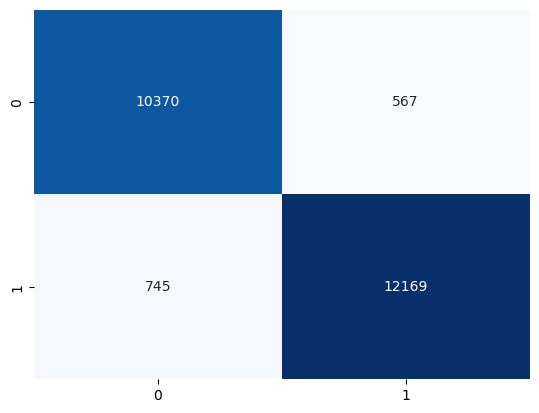

In [79]:
cf_matrix = confusion_matrix(y_test_encoded, y_test_pred)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

## 2.4. feature Importance

### Base decision tree

Feature: 0, Score: 0.01572
Feature: 1, Score: 0.01981
Feature: 2, Score: 0.14234
Feature: 3, Score: 0.02612
Feature: 4, Score: 0.01472
Feature: 5, Score: 0.03192
Feature: 6, Score: 0.00653
Feature: 7, Score: 0.43396
Feature: 8, Score: 0.01955
Feature: 9, Score: 0.08428
Feature: 10, Score: 0.00895
Feature: 11, Score: 0.01467
Feature: 12, Score: 0.01501
Feature: 13, Score: 0.01975
Feature: 14, Score: 0.01917
Feature: 15, Score: 0.01891
Feature: 16, Score: 0.00462
Feature: 17, Score: 0.00814
Feature: 18, Score: 0.04351
Feature: 19, Score: 0.00679
Feature: 20, Score: 0.00759
Feature: 21, Score: 0.01427
Feature: 22, Score: 0.02285
Feature: 23, Score: 0.00045
Feature: 24, Score: 0.00038


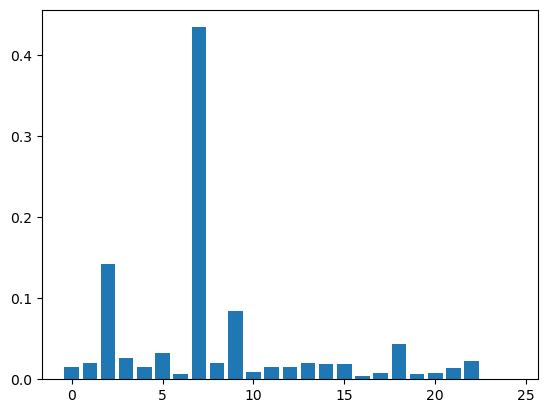

In [82]:
importance = optimal_tree.feature_importances_

for i, v in enumerate(importance):
    print(f'Feature: {i}, Score: {v:.5f}')
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [84]:
#Displaying the most important features in descending order
key_features= {}
for col, val in sorted(zip(X_train_dt.columns, optimal_tree.feature_importances_),key=lambda x:x[1],reverse=True):
  key_features[col]=val
    
feat_df_1 = pd.DataFrame({'Feature':key_features.keys(),'Importance':key_features.values()})

feat_df_1

,Feature,Importance
0,Inflight entertainment,0.433956
1,Seat comfort,0.142342
2,Ease of Online booking,0.084284
3,Customer Type_Loyal Customer,0.043507
4,Gate location,0.031917
5,Departure/Arrival time convenient,0.026119
6,Class_Business,0.022849
7,Flight Distance,0.019810
8,Checkin service,0.019749
9,Online support,0.019550


### Bagging added

In [87]:
# Compute average feature importances across all trees in the bagging model
avg_importances = np.mean(
    [tree.feature_importances_ for tree in bagging_model.estimators_], axis=0
)

# Sort features by importance
key_features = {}
for col, val in sorted(zip(X_train_dt.columns, avg_importances), key=lambda x: x[1], reverse=True):
    key_features[col] = val

# Create DataFrame
feat_df_2 = pd.DataFrame({'Feature': key_features.keys(), 'Importance': key_features.values()})

feat_df_2

,Feature,Importance
0,Inflight entertainment,0.415360
1,Seat comfort,0.136178
2,Ease of Online booking,0.079067
3,Flight Distance,0.031193
4,Gate location,0.028581
5,Departure/Arrival time convenient,0.026404
6,Customer Type_disloyal Customer,0.024396
7,Age,0.023477
8,Checkin service,0.022521
9,Customer Type_Loyal Customer,0.022011


### AdaBoost

In [92]:
# Use the fitted best model from GridSearchCV
best_adaboost_model.fit(X_train_dt, y_train_encoded)

# AdaBoost has a built-in feature_importances_ attribute
feat_importances = best_adaboost_model.feature_importances_

# Create a DataFrame
feat_df_3 = pd.DataFrame({
    'Feature': X_train_dt.columns,
    'Importance': feat_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

feat_df_3

C:\Users\Lukasz\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Feature,Importance
0,Flight Distance,0.110442
1,Seat comfort,0.096267
2,Age,0.088092
3,Inflight entertainment,0.062626
4,Online support,0.052496
5,Ease of Online booking,0.050971
6,Gate location,0.047010
7,Baggage handling,0.045999
8,Departure/Arrival time convenient,0.041845
9,Cleanliness,0.038960


In [94]:
# Rename importance columns to identify models
df1 = feat_df_1.rename(columns={'Importance': 'Decision Tree'})
df2 = feat_df_2.rename(columns={'Importance': 'Bagging'})
df3 = feat_df_3.rename(columns={'Importance': 'AdaBoost'})

# Merge on Feature
merged_df = df1.merge(df2, on='Feature').merge(df3, on='Feature')

# Keep top 10 features based on average importance
merged_df['Mean_Importance'] = merged_df[['Decision Tree','Bagging','AdaBoost']].mean(axis=1)
top_features = merged_df.sort_values('Mean_Importance', ascending=False).head(10)

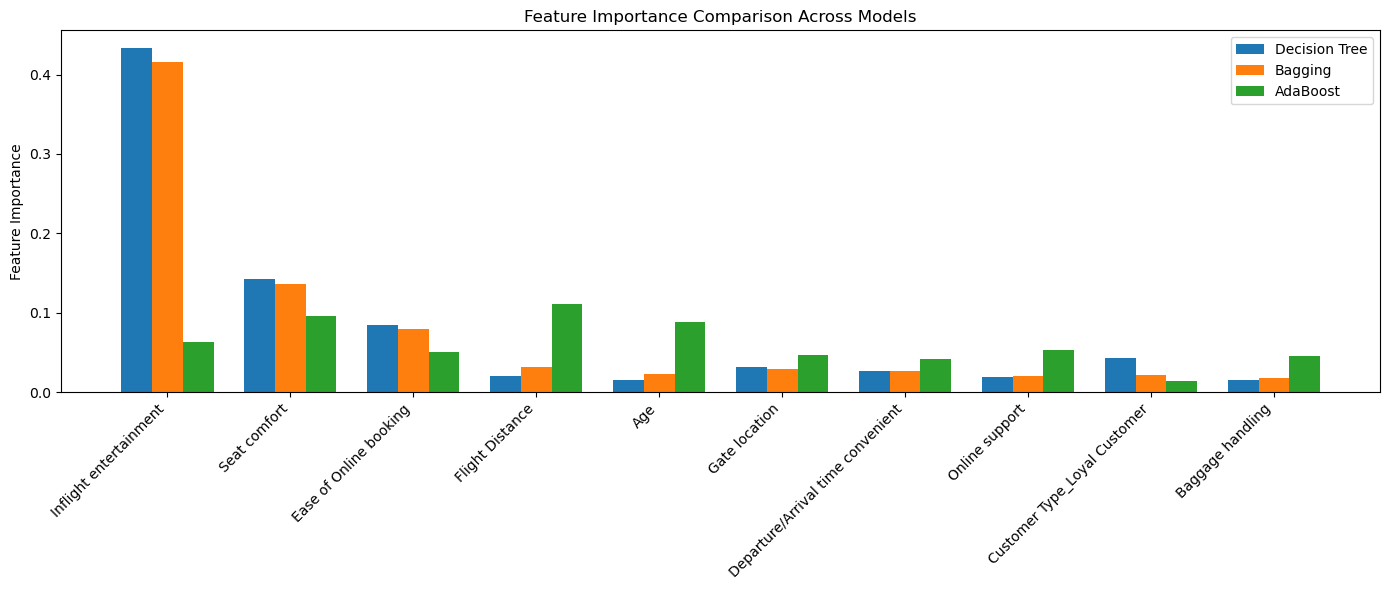

In [96]:
x = np.arange(len(top_features))
width = 0.25

plt.figure(figsize=(14,6))
plt.bar(x - width, top_features['Decision Tree'], width, label='Decision Tree')
plt.bar(x,         top_features['Bagging'], width, label='Bagging')
plt.bar(x + width, top_features['AdaBoost'], width, label='AdaBoost')

plt.xticks(x, top_features['Feature'], rotation=45, ha='right')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Comparison Across Models')
plt.legend()
plt.tight_layout()
plt.show()

1. Decision Tree

The Decision Tree assigns a very large importance to a small number of features, most notably:

- `Inflight entertainment`

- `Seat comfort`

- `Ease of online booking`

This concentration is typical of single decision trees, which tend to rely heavily on the earliest (top-level) splits.
As a result, the model is highly interpretable but more prone to overfitting, since decisions are dominated by a few variables.

2. Bagging

The Bagging model shows a pattern similar to the decision tree but with slightly smoother importance values.

Key features such as `Inflight entertainment` and `Seat comfort` remain dominant. However, importance is less extreme, as bagging averages results across multiple trees trained on bootstrap samples.This indicates reduced variance and improved robustness compared to a single tree.

3. AdaBoost

AdaBoost distributes importance much more evenly across features.

Variables such as:
- `Flight Distance`
- `Age`
- `On-board service`
- `Check-in service`

contribute more meaningfully compared to the other models. This occurs because AdaBoost focuses on instances that were previously underfited and improves on the previous errors since AdaBoost is built on the misclasifications of previous classifiers